In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_addons as tfa
import pandas as pd
from pathlib import Path
import os.path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import r2_score
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from natsort import natsorted, ns

Create DataFrame

In [3]:
#read the filepaths for each image
filepaths = pd.Series(list(glob.iglob('soilSpec/dataset/images/*.png' )), name='Filepath').astype(str)
#read the csv values
df = pd.read_csv('soilSpec/dataset/VNIR_spec_master_horizon_A&B.csv', low_memory=False)
print(" Reading - Done!")

 Reading - Done!


Pre-Process Data

                                Filepath        OC
0          soilSpec/dataset/images/0.png  3.965373
1          soilSpec/dataset/images/1.png  1.621653
2          soilSpec/dataset/images/2.png  0.805019
3          soilSpec/dataset/images/3.png  0.459820
4          soilSpec/dataset/images/4.png  0.330312
...                                  ...       ...
14495  soilSpec/dataset/images/14495.png  0.173780
14496  soilSpec/dataset/images/14496.png  3.128896
14497  soilSpec/dataset/images/14497.png  0.506926
14498  soilSpec/dataset/images/14498.png  0.291173
14499  soilSpec/dataset/images/14499.png  4.492627

[13779 rows x 2 columns]
image dataFrame created!


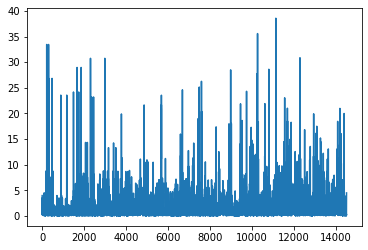

In [4]:
#Sort image paths acceding order
filepaths = pd.Series(list(natsorted(filepaths, key=lambda y: y.lower())), name='Filepath').astype(str)
#df = df2

#df = df.drop(df.iloc[:, 0:34],axis = 1)
#df = df.drop(df.iloc[:, 1:8],axis = 1)
df = df.drop(df.index[14500:])

dataCols =  df['EOC']
plt.plot(dataCols)
thresh = 5
#df2= df[df['EOC']<thresh]

       
OC = pd.Series(df['EOC'].tolist(), name= 'OC')
#Image paths concatenated with relavent OC value
images = pd.concat([filepaths, OC], axis=1)

images = images.dropna()

images= images[images['OC']<thresh]
#images = images.drop(images.index[740:])
print(images)
print("image dataFrame created!")
#print(filepaths.sort_values(ascending=True))

Split Dataset

In [5]:
#Split train data= 0.5 , test data = 0.3, validation data=0.2
train_df, test_df = train_test_split(images, train_size=0.5, shuffle=True, random_state=1)
test_df, val_df = train_test_split(test_df, train_size=0.6, shuffle=True, random_state=1)

Load Images

In [6]:
batchSize = 16
width = 80
height = 60
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='OC',
    target_size=(width, height),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batchSize,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='OC',
    target_size=(width, height),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batchSize,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='OC',
    target_size=(width, height),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batchSize,
    shuffle=False
)

Found 5512 validated image filenames.
Found 551 validated image filenames.
Found 4134 validated image filenames.


MLP Function

In [7]:
#MLP with Two Dense Layers
# Multilayer Perceptron with GeLU ( Gaussian Linear Units ) activation
def mlp( x , hidden_dims ):
    y = tf.keras.layers.Dense( hidden_dims )( x )
    y = tf.nn.gelu( y )
    y = tf.keras.layers.Dense( x.shape[ -1 ] )( y )
    y = tf.keras.layers.Dropout( 0.4 )( y )
    return y

Mixer Layer

In [8]:
#Mixer layer consisting of token mixing MLPs and channel mixing MLPs
# input shape -> ( batch_size , channels , num_patches )
# output shape -> ( batch_size , channels , num_patches )
def mixer( x , token_mixing_mlp_dims , channel_mixing_mlp_dims ):
    # inputs x of are of shape ( batch_size , num_patches , channels )
    # Note: "channels" is used instead of "embedding_dims"
    
    # Add token mixing MLPs
    token_mixing_out = token_mixing( x , token_mixing_mlp_dims )
    # Shape of token_mixing_out -> ( batch_size , channels , num_patches )

    token_mixing_out = tf.keras.layers.Permute( dims=[ 2 , 1 ] )( token_mixing_out )
    # Shape of transposition -> ( batch_size , num_patches , channels )
    
    #  Add skip connection
    token_mixing_out = tf.keras.layers.Add()( [ x , token_mixing_out ] )

    # Add channel mixing MLPs
    channel_mixing_out = channel_mixing( token_mixing_out , channel_mixing_mlp_dims )
    # Shape of channel_mixing_out -> ( batch_size , num_patches , channels )
    
    # Add skip connection
    channel_mixing_out = tf.keras.layers.Add()( [ channel_mixing_out , token_mixing_out ] )
    # Shape of channel_mixing_out -> ( batch_size , num_patches , channels )

    return channel_mixing_out

Token Mixing

In [9]:
# Token Mixing MLPs : Allow communication within patches.
def token_mixing( x , token_mixing_mlp_dims ):
    # x is a tensor of shape ( batch_size , num_patches , channels )
    x = tf.keras.layers.LayerNormalization( epsilon=1e-6 )( x )
    x = tf.keras.layers.Permute( dims=[ 2 , 1 ] )( x ) 
    # After transposition, shape of x -> ( batch_size , channels , num_patches )
    x = mlp( x , token_mixing_mlp_dims )
    return x

Channel Mixing

In [10]:
# Channel Mixing MLPs : Allow communication within channels ( features of embeddings )
def channel_mixing( x , channel_mixing_mlp_dims ):
    # x is a tensor of shape ( batch_size , num_patches , channels )
    x = tf.keras.layers.LayerNormalization( epsilon=1e-6 )( x )
    x = mlp( x , channel_mixing_mlp_dims )
    return x

Model

In [19]:
hidden_dims = 32
token_mixing_mlp_dims = 64
channel_mixing_mlp_dims = 64
patch_size = 9
num_classes = 10
num_mixer_layers = 4
input_image_shape = ( 80 , 60 , 3 )

inputs = tf.keras.layers.Input( shape=input_image_shape )

# Conv2D to extract patches
patches = tf.keras.layers.Conv2D( hidden_dims , kernel_size=patch_size , strides=patch_size )( inputs )
# Resizing the patches
patches_reshape = tf.keras.layers.Reshape( ( patches.shape[ 1 ] * patches.shape[ 2 ] , patches.shape[ 3 ] ) )( patches )

x = patches_reshape
for _ in range( num_mixer_layers ):
    x = mixer( x , token_mixing_mlp_dims , channel_mixing_mlp_dims )

# Classifier head
x = tf.keras.layers.LayerNormalization( epsilon=1e-6 )( x )
# = tf.keras.layers.GlobalAveragePooling1D()( x )
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense( 1, activation='linear')( x )
# outputs = tf.keras.layers.Dense( 1)( x )

model = tf.keras.models.Model( inputs , outputs )
optimizer = tf.keras.optimizers.Adam(lr=0.001)
# The loss function is 'mse', since it is regression
model.compile(
    optimizer=optimizer,
    loss='mse'
)




from keras import backend as K
#K.set_value(model.optimizer.learning_rate, 0.001)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(
    #         monitor='val_loss',
    #         patience=5,
    #         restore_best_weights=True
    #     )
    # ]
)

Epoch 1/50
345/345 [==============================] - 7s 15ms/step - loss: 1.6588 - val_loss: 1.0784
Epoch 2/50
345/345 [==============================] - 5s 13ms/step - loss: 1.2194 - val_loss: 1.0507
Epoch 3/50
345/345 [==============================] - 5s 13ms/step - loss: 1.1885 - val_loss: 1.0563
Epoch 4/50
345/345 [==============================] - 5s 13ms/step - loss: 1.1247 - val_loss: 1.0730
Epoch 5/50
345/345 [==============================] - 5s 13ms/step - loss: 1.0143 - val_loss: 0.6539
Epoch 6/50
345/345 [==============================] - 5s 13ms/step - loss: 0.8024 - val_loss: 0.6120
Epoch 7/50
345/345 [==============================] - 5s 13ms/step - loss: 0.7454 - val_loss: 0.5079
Epoch 8/50
345/345 [==============================] - 5s 13ms/step - loss: 0.7012 - val_loss: 0.5534
Epoch 9/50
345/345 [==============================] - 5s 13ms/step - loss: 0.6820 - val_loss: 0.5241
Epoch 10/50
345/345 [==============================] - 4s 13ms/step - loss: 0.6588 - val_lo

Results

     Test RMSE: 0.61920
Test R^2 Score: 0.65517
4.5515037


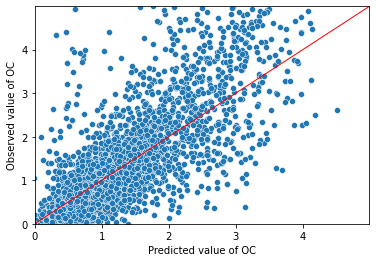

       true_OC  predicted_OC
0     1.115503      1.284119
1     2.380554      1.404996
2     0.161774      0.591156
3     0.180321      0.327779
4     1.342232      1.326870
...        ...           ...
4129  0.495813      0.525341
4130  0.145479      0.339715
4131  0.139476      0.447966
4132  0.530832      0.626137
4133  0.157875      0.346268

[4134 rows x 2 columns]


In [20]:
predicted_OC = np.squeeze(model.predict(test_images))

true_OC = test_images.labels
df10 = pd.DataFrame({'true_OC' : true_OC, 'predicted_OC' : predicted_OC})   
#df10.to_csv('/home/yasindu/Desktop/Datasets/predictions.csv', index=False, encoding='utf-8')
# SQroot of Mean squared error
rmse = np.sqrt(model.evaluate(test_images, verbose=0))
print("     Test RMSE: {:.5f}".format(rmse))


r2 = r2_score(true_OC, predicted_OC)
print("Test R^2 Score: {:.5f}".format(r2))
#plt.figure()
#sns.scatterplot(x=true_OC, y=predicted_OC, alpha=0.6)
#sns.lineplot(true_OC, predicted_OC)
#plt.xlabel('Actual OC', fontsize=14)
#plt.ylabel('Prediced  OC', fontsize=14)
#plt.title(f'Actual vs Predicted  OC (test set) T = {thresh}', fontsize=17)
#plt.show()

print(predicted_OC.max()-predicted_OC.min())
#sns.regplot(x=true_OC, y=predicted_OC)

true_OC_max = true_OC.max()
true_OC_min = true_OC.min()

ax = sns.scatterplot(x=predicted_OC, y=true_OC)
ax.set(ylim=(true_OC_min, true_OC_max))
ax.set(xlim=(true_OC_min, true_OC_max))
ax.set_xlabel("Predicted value of OC")
ax.set_ylabel("Observed value of OC")

X_ref = Y_ref = np.linspace(true_OC_min, true_OC_max, 100)
plt.plot(X_ref, Y_ref, color='red', linewidth=1)
plt.show()
#plt.savefig("soilSpec/dataset/plotuno75x40.png")
plt.close()
print(df10)

Loss

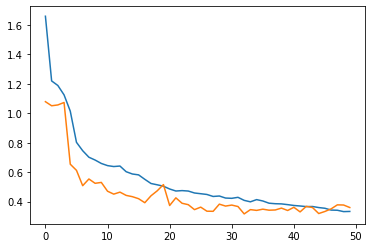

In [21]:
his = history.history
plt.figure()
plt.plot(his['loss'])
plt.plot(his['val_loss'])
#plt.savefig("soilSpec/dataset/lossuno75x40.png")
#plt.close()